In [1]:
import numpy as np
import pandas as pd
import scipy as sp

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn import linear_model
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline 

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [4]:
#add batch numbers
df_train['batch'] = 0
batch_index = [i for i in range(0,5000001,500000)]
for i in range(10):
        df_train.loc[batch_index[i]:batch_index[i+1]+1,'batch'] = i

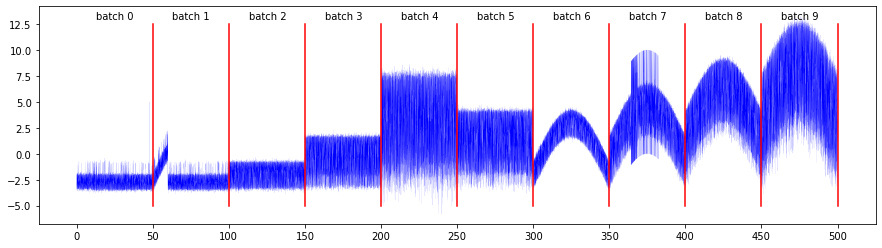

In [5]:
fig, axs = plt.subplots(figsize=(15, 4))
axs.plot(df_train['time'],df_train['signal'],color='blue',linewidth=.05)

for batch in df_train['batch'].unique():
    x = float(df_train.loc[df_train['batch']==batch, 'time'][-1:])
    x = np.array([x,x])
    y = np.array([-5,12.5])
    axs.plot(x,y,color='red')
    axs.annotate(f'batch {batch}', xy = (x[0]-37,13))
    plt.xticks(np.arange(0, 501, 50))

In [6]:
df_train['remove_drift'] = df_train['signal'].values

In [7]:
df_batch_1 = df_train.loc[df_train['batch']==1].copy()

In [8]:
df_batch_1_1 = df_batch_1.loc[df_batch_1['time']<=60].copy()
df_batch_1_2 = df_batch_1.loc[df_batch_1['time']>60].copy()

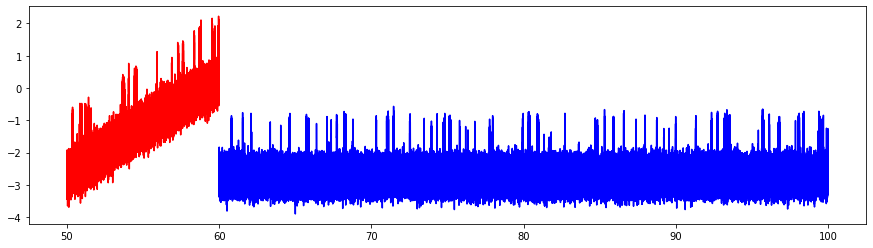

In [9]:
plt.subplots(figsize=(15, 4))
plt.plot(df_batch_1_1['time'], df_batch_1_1['signal'], '-r' )
plt.plot(df_batch_1_2['time'], df_batch_1_2['signal'], '-b' )

# First method remove drift with polynom use

In [ ]:
train_x = np.asanyarray(df_batch_1_1[['time']])
train_y = np.asanyarray(df_batch_1_1[['signal']])

In [ ]:
poly = PolynomialFeatures(degree=2)
train_x_poly = poly.fit_transform(train_x)

clf = linear_model.LinearRegression()
clf = clf.fit(train_x_poly, train_y)

In [ ]:
XX = np.arange(50.0001, 60.0001, 0.0001)
yy = clf.intercept_[0] + clf.coef_[0][1]*XX + clf.coef_[0][2]*np.power(XX, 2)

In [ ]:
df_train.loc[500000:599999, 'remove_drift'] = (df_train.loc[500000:599999, 'signal'] - yy) + yy[0]

In [ ]:
for batch in range(6,10):
    df_batch = df_train.loc[df_train['batch']==batch].copy()
    
    t_start = float(df_batch['time'][:1])
    t_end = float(df_batch['time'][-1:]+0.0001)
    
    train_x = np.asanyarray(df_batch[['time']])
    train_y = np.asanyarray(df_batch[['signal']])
    
    poly = PolynomialFeatures(degree=4)
    train_x_poly = poly.fit_transform(train_x)
    
    clf = linear_model.LinearRegression()
    train_y_hat = clf.fit(train_x_poly, train_y)
    
    XX = np.arange(t_start, t_end, 0.0001)
    yy = (clf.intercept_[0]+clf.coef_[0][1]*XX
          +clf.coef_[0][2]*np.power(XX, 2)
          +clf.coef_[0][3]*np.power(XX, 3)
          +clf.coef_[0][4]*np.power(XX, 4))
      
    df_train.loc[df_train['batch']==batch, 'remove_drift'] = (df_train.loc[df_train['batch']==batch, 'signal'] - yy) + yy[0]

In [ ]:
fig, axs = plt.subplots(figsize=(15, 4))
axs.plot(df_train['time'],df_train['remove_drift'], linewidth=.05 ,color='blue')

for batch in df_train['batch'].unique():
    x = float(df_train.loc[df_train['batch']==batch, 'time'][-1:])
    x = np.array([x,x])
    y = np.array([-5,12.5])
    axs.plot(x,y,color='red') 
    axs.annotate(f'batch {batch}', xy = (x[0]-37,10))

# Remove drift with sin func use

In [10]:
def my_sin(x, A, ph, d):
    frequency = 0.01 # 1/50*2 s  (50 is 1/2 T)
    omega = 2 * np.pi * frequency
    return A * np.sin(omega * x + ph) + d

In [11]:
popt, _ = curve_fit(my_sin, df_batch_1_1['time'], df_batch_1_1['signal'])

In [12]:
yy = my_sin(df_batch_1_1['time'],popt[0],popt[1],popt[2])

In [13]:
df_train.loc[500000:599999, 'remove_drift'] = (df_train.loc[500000:599999, 'signal'] - yy) + yy.values[0]

In [14]:
for batch in range(6,10):
    df_batch = df_train.loc[df_train['batch']==batch].copy()
    popt, _ = curve_fit(my_sin, df_batch['time'], df_batch['signal'])
    yy = my_sin(df_batch['time'],popt[0],popt[1],popt[2]) 
    
    df_train.loc[df_train['batch']==batch, 'remove_drift'] = (
        df_train.loc[df_train['batch']==batch, 'signal'] - yy) + yy.values[0]

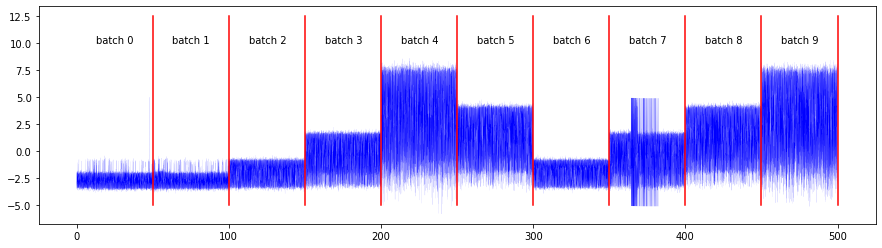

In [15]:
fig, axs = plt.subplots(figsize=(15, 4))
axs.plot(df_train['time'],df_train['remove_drift'], linewidth=.05 ,color='blue')

for batch in df_train['batch'].unique():
    x = float(df_train.loc[df_train['batch']==batch, 'time'][-1:])
    x = np.array([x,x])
    y = np.array([-5,12.5])
    axs.plot(x,y,color='red') 
    axs.annotate(f'batch {batch}', xy = (x[0]-37,10))

In [16]:
print(f'Размер тренировочного сета: {df_train.shape[0]} объектов')
print(f'Количество объектов в тренировочном сете где целевая переменная больше нуля: {df_train.loc[df_train["open_channels"]>0].shape[0]}')
print(f'Количество уникальных signal: {df_train["remove_drift"].unique().shape[0]}')      

Размер тренировочного сета: 5000000 объектов
Количество объектов в тренировочном сете где целевая переменная больше нуля: 3759848
Количество уникальных signal: 2173200


In [17]:
df_train.describe()

,time,signal,open_channels,batch,remove_drift
count,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06
mean,2.500001e+02,1.386246e+00,2.726043e+00,4.500000e+00,7.302049e-02
std,1.443376e+02,3.336219e+00,2.665051e+00,2.872282e+00,2.478891e+00
min,1.000000e-04,-5.796500e+00,0.000000e+00,0.000000e+00,-5.796500e+00
25%,1.250001e+02,-1.594800e+00,1.000000e+00,2.000000e+00,-2.104000e+00
50%,2.500000e+02,1.124000e+00,2.000000e+00,4.500000e+00,-3.375916e-01
75%,3.750000e+02,3.690100e+00,4.000000e+00,7.000000e+00,1.972264e+00
max,5.000000e+02,1.324400e+01,1.000000e+01,9.000000e+00,8.613100e+00


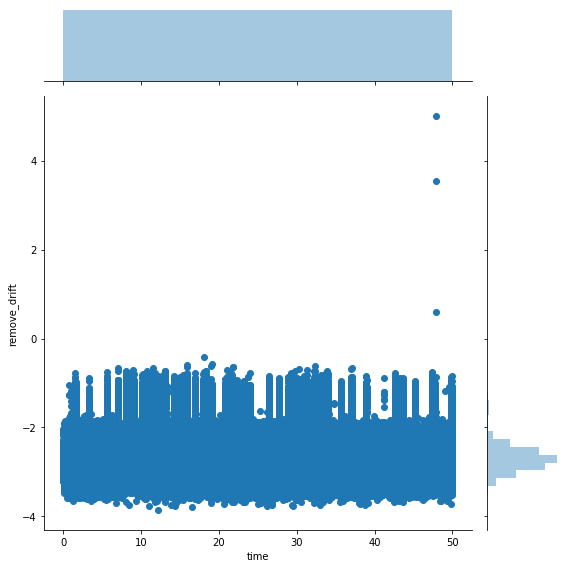

In [18]:
sns.jointplot(x = 'time', y= 'remove_drift', data = df_train.loc[df_train['batch']==0], height=8)
plt.show()

In [19]:
index_del = df_train.loc[(df_train['batch']==0)&(df_train['remove_drift']>0)].index

In [20]:
df_train_drop_max = df_train.loc[df_train['batch']==0].copy()
df_train_drop_max.drop(df_train_drop_max.index[index_del], inplace=True)

In [21]:
max_ = df_train_drop_max['remove_drift'].max()

In [22]:
df_train.loc[(df_train['batch']==0)&(df_train['remove_drift']>0), 'remove_drift'] = max_

In [23]:
df_train.loc[df_train['batch']==3]['remove_drift'].describe()

count    500000.000000
mean         -0.092984
std           1.002793
min          -3.707300
25%          -0.592000
50%          -0.134000
75%           0.830400
max           2.240400
Name: remove_drift, dtype: float64

In [24]:
df_train.loc[df_train['batch']==7]['remove_drift'].describe()

count    500000.000000
mean         -0.169318
std           1.170210
min          -5.088975
25%          -0.721932
50%          -0.192411
75%           0.767703
max           4.938712
Name: remove_drift, dtype: float64

In [25]:
max_ = df_train.loc[df_train['batch']==3]['remove_drift'].max()
min_ = df_train.loc[df_train['batch']==3]['remove_drift'].min()

In [26]:
df_train.loc[(df_train['batch']==7)&(df_train['remove_drift']>max_), 'remove_drift'] = max_
df_train.loc[(df_train['batch']==7)&(df_train['remove_drift']<min_), 'remove_drift'] = min_

In [ ]:
count, bin_signal = np.histogram(df_train['remove_drift'], 15)
count, bin_number = np.histogram(df_train['open_channels'], 10)

fig, axs = plt.subplots(1, 2, figsize=(15, 4), sharey=True)
axs[0].hist(df_train['remove_drift'],
            bins=bin_signal,
            color='coral')
axs[1].hist(df_train['open_channels'],
            bins=bin_number,
            color='darkslateblue')

In [ ]:
# Подсчет целевых значений
df_number_chan = df_train['open_channels'].value_counts().to_frame().reset_index()
df_number_chan.rename(columns={'index': 'number_open_channels','open_channels':'count_open_channels'}, inplace=True)

fig, axs = plt.subplots(1, 1, figsize=(15, 4), sharey=True)
sns.barplot(x=df_number_chan['number_open_channels'], y=df_number_chan['count_open_channels'], palette="rocket", ax=axs)
#axs.bar(df_number_chan['number_open_channels'], df_number_chan['count_open_channels'])
plt.ylabel('Count open channels')
plt.xlabel('Number open channels')
fig.suptitle('Counts number open channel')

In [ ]:
# date for bild heatmap
count, bin_signal = np.histogram(df_train['remove_drift'], 11)
dict_heatmap = {}
list_heatmap = []

for bin_index in range(11):
    
    for open_channels in  range(11):
        dict_heatmap['bin'] = round(bin_signal[bin_index+1])
        dict_heatmap['number_open_channels'] = open_channels
        dict_heatmap['count_open_channels'] = df_train.loc[(df_train['open_channels']==open_channels)
                     &(df_train['remove_drift']>bin_signal[bin_index])
                     &(df_train['remove_drift']<bin_signal[bin_index+1])
                     ,'open_channels'].count()
        list_heatmap.append(dict_heatmap.copy())

In [ ]:
df_heatmap = pd.DataFrame(list_heatmap)
df_heatmap = df_heatmap.pivot('bin', 'number_open_channels', 'count_open_channels')

In [ ]:
fig, axs = plt.subplots(figsize=(8, 7))
sns.heatmap(df_heatmap, annot=True, fmt="d", linewidths=.8, ax=axs)

In [ ]:
list_df_heatmap = []

for batch in range(10):
    dict_heatmap = {}
    list_heatmap = []
    df_train_batch = df_train.loc[df_train['batch']==batch].copy()
    count, bin_signal = np.histogram(df_train_batch['remove_drift'], 4)
    for bin_index in range(4):       
        for open_channels in  range(11):
            dict_heatmap['bin_signal'] = round(bin_signal[bin_index+1])
            dict_heatmap['number_open_channels'] = open_channels
            dict_heatmap['count_open_channels'] = df_train_batch.loc[(df_train['open_channels']==open_channels)
                         &(df_train['remove_drift']>bin_signal[bin_index])
                         &(df_train['remove_drift']<bin_signal[bin_index+1])
                         ,'open_channels'].count()
            list_heatmap.append(dict_heatmap.copy())
    df_heatmap = pd.DataFrame(list_heatmap)
    list_df_heatmap.append(df_heatmap.pivot('bin_signal', 'number_open_channels', 'count_open_channels'))

In [ ]:
plt.figure(figsize=(26, 22))
plt.subplots_adjust(top=1.2, hspace = 0.8)
for i, b in enumerate(df_train['batch'].unique()):
    plt.subplot(5, 2, i + 1)
    plt.title(f'Batch: {b}')
    sns.heatmap(list_df_heatmap[i], linewidths=.5,  annot=True, fmt="d", cmap="YlGnBu")   
    plt.grid(False)

In [ ]:
different_batch = [0,2,3,4,5,7]
plt.figure(figsize=(26, 22))
plt.subplots_adjust(top=1.2, hspace = 0.8)
for i, b in enumerate(different_batch):
    plt.subplot(5, 2, i + 1)
    plt.title(f'Batch: {b}')
    batch = df_train.loc[df_train['batch']==b]
    #sns.distplot(batch['open_channels'], kde=False, color="m")
    sns.distplot(batch['remove_drift'], kde=False, color="m")
    plt.grid(False)

In [ ]:
for b,i in zip(range(11),range(10)):
    batch = df_train.loc[df_train['batch']==b]
    sns.jointplot(batch['open_channels'], batch['remove_drift'], kind="hex")

In [ ]:
info_dict = {}
info_list = []
info_open_channels = []
for b in range(10):
    batch = df_train.loc[df_train['batch']==b].copy()
    info_dict['batch'] = b
    info_dict['min_signal'] = batch['remove_drift'].min()
    info_dict['max_signal'] = batch['remove_drift'].max()
    info_dict['mean_signal'] = batch['remove_drift'].mean()
    info_open_channels.append(batch['open_channels'].value_counts().to_dict())
    info_list.append(info_dict.copy())
df_info = pd.DataFrame(info_list)
df_open_channels = pd.DataFrame(info_open_channels)
df_open_channels.fillna(0,inplace = True)
df_info = pd.concat([df_info, df_open_channels], axis = 1)

In [27]:
df_test.head()

,time,signal
0,500.0001,-2.6498
1,500.0002,-2.8494
2,500.0003,-2.8600
3,500.0004,-2.4350
4,500.0005,-2.6155


In [28]:
print(f'Размер тестовых данных: {df_test.shape}')

Размер тестовых данных: (2000000, 2)


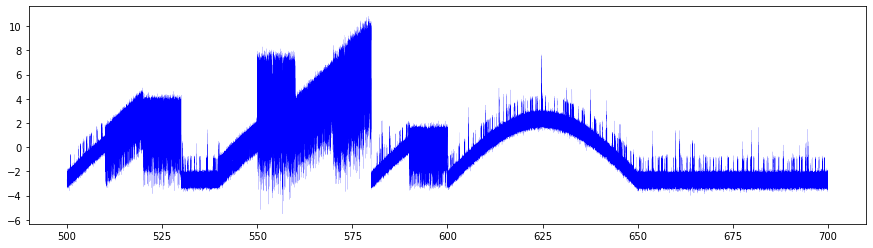

In [29]:
fig, axs = plt.subplots(figsize=(15, 4))
axs.plot(df_test['time'],df_test['signal'],linewidth=.1,color='blue')

In [30]:
df_test['remove_drift'] = df_test['signal'].values

In [31]:
#add batch numbers
df_test['batch'] = 0
batch_index = [i for i in range(0,2000001,500000)]
for i in range(4):
        df_test.loc[batch_index[i]:batch_index[i+1]+1,'batch'] = i

In [32]:
#add sub_batch numbers
df_test['sub_batch'] = 0
sub_batch_index = [i for i in range(0,2000001,100000)]
for i in range(20):
        df_test.loc[sub_batch_index[i]:sub_batch_index[i+1]+1,'sub_batch'] = i

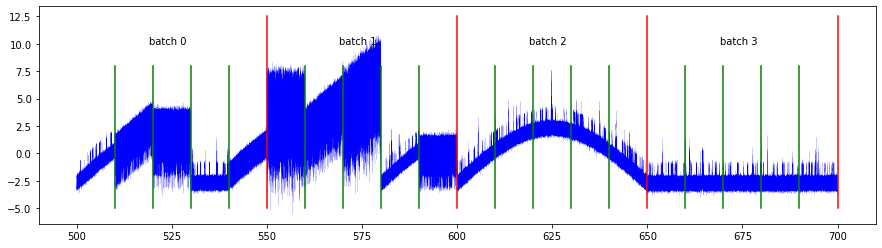

In [33]:
fig, axs = plt.subplots(figsize=(15, 4))
axs.plot(df_test['time'],df_test['signal'],linewidth=.1,color='blue')

for batch in df_test['batch'].unique():
    x = float(df_test.loc[df_test['batch']==batch, 'time'][-1:])
    x = np.array([x,x])
    y = np.array([-5,12.5])
    axs.plot(x,y,color='red') 
    axs.annotate(f'batch {batch}', xy = (x[0]-31,10))
    
not_plot = [4, 9, 14, 19]    
for sub_batch in df_test['sub_batch'].unique():
    boole = sub_batch in not_plot
    if not boole:
        x = float(df_test.loc[df_test['sub_batch']==sub_batch, 'time'][-1:])
        x = np.array([x,x])
        y = np.array([-5,8])
        axs.plot(x,y,color='green') 

# First method

In [ ]:
df_linear_drift = df_test.loc[df_test['time']<=600]
df_poly_drift = df_test.loc[(df_test['time']>600)&(df_test['time']<=650)]

In [ ]:
for sub_batch in range(10):
    
    df_sub_batch = df_linear_drift.loc[df_linear_drift['sub_batch'] == sub_batch]
    t_start = float(df_linear_drift.loc[df_linear_drift['sub_batch']== sub_batch, 'time'][:1])
    t_end = float(df_linear_drift.loc[df_linear_drift['sub_batch']== sub_batch, 'time'][-1:]+0.0001)
    
    train_x = np.asanyarray(df_sub_batch[['time']])
    train_y = np.asanyarray(df_sub_batch[['signal']])
    
    poly = PolynomialFeatures(degree=2)
    train_x_poly = poly.fit_transform(train_x)
    
    clf = linear_model.LinearRegression()
    train_y_hat = clf.fit(train_x_poly, train_y)
    
    XX = np.arange(t_start, t_end, 0.0001)
    yy = clf.intercept_[0] + clf.coef_[0][1]*XX + clf.coef_[0][2]*np.power(XX, 2)
      
    df_linear_drift.loc[df_linear_drift['sub_batch'] == sub_batch, 'remove_drift'] = (
        df_linear_drift.loc[df_linear_drift['sub_batch'] == sub_batch]['signal'].values - yy)+yy[0]

In [ ]:
t_start = float(df_poly_drift['time'][:1])
t_end = float(df_poly_drift['time'][-1:]+0.0001)
    
train_x = np.asanyarray(df_poly_drift[['time']])
train_y = np.asanyarray(df_poly_drift[['signal']])
    
poly = PolynomialFeatures(degree=4)
train_x_poly = poly.fit_transform(train_x)
    
clf = linear_model.LinearRegression()
train_y_hat = clf.fit(train_x_poly, train_y)
    
XX = np.arange(t_start, t_end, 0.0001)
yy = (clf.intercept_[0]+clf.coef_[0][1]*XX
      +clf.coef_[0][2]*np.power(XX, 2)
      +clf.coef_[0][3]*np.power(XX, 3)
      +clf.coef_[0][4]*np.power(XX, 4))
      
df_poly_drift['remove_drift'] = (df_poly_drift['signal'].values - yy) + yy[0]

In [ ]:
df_test.loc[df_test['time']<=600, 'remove_drift'] = df_linear_drift['remove_drift'].values
df_test.loc[(df_test['time']>600)&(df_test['time']<=650), 'remove_drift'] = df_poly_drift['remove_drift'].values

In [ ]:
plt.subplots(figsize=(15, 4))
plt.plot(train_x, train_y, linewidth=.05, color='red')
plt.plot(XX, yy, '-b' )
plt.plot(XX, df_poly_drift['remove_drift'], linewidth=.05, color='green')

# Second method

In [34]:
sub_batch_drift = [0,1,4,6,7,8]
batch_drift = [2]

In [35]:
for sub_batch in sub_batch_drift:
    df_sub_batch = df_test.loc[df_test['sub_batch']==sub_batch].copy()
    popt, _ = curve_fit(my_sin, df_sub_batch['time'], df_sub_batch['signal'])
    yy = my_sin(df_sub_batch['time'],popt[0],popt[1],popt[2]) 
    
    df_test.loc[df_test['sub_batch']==sub_batch, 'remove_drift'] = (
        df_test.loc[df_test['sub_batch']==sub_batch, 'signal'] - yy) + yy.values[0]

In [36]:
df_batch = df_test.loc[df_test['batch']==2].copy()
popt, _ = curve_fit(my_sin, df_batch['time'], df_batch['signal'])
yy = my_sin(df_batch['time'],popt[0],popt[1],popt[2]) 
    
df_test.loc[df_test['batch']==2, 'remove_drift'] = (
df_test.loc[df_test['batch']==2, 'signal'] - yy) + yy.values[0]

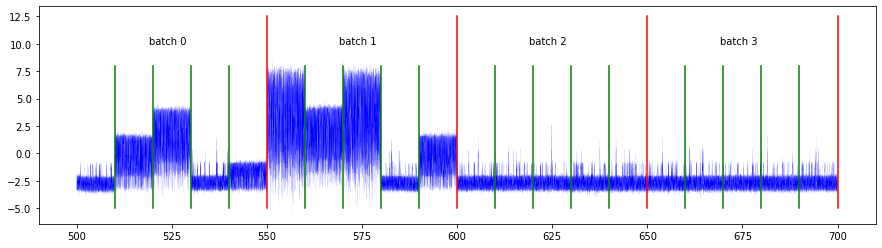

In [37]:
fig, axs = plt.subplots(figsize=(15, 4))
axs.plot(df_test['time'],df_test['remove_drift'], linewidth=.05, color='blue')

for batch in df_test['batch'].unique():
    x = float(df_test.loc[df_test['batch']==batch, 'time'][-1:])
    x = np.array([x,x])
    y = np.array([-5,12.5])
    axs.plot(x,y,color='red') 
    axs.annotate(f'batch {batch}', xy = (x[0]-31,10))
    
not_plot = [4, 9, 14, 19]    
for sub_batch in df_test['sub_batch'].unique():
    boole = sub_batch in not_plot
    if not boole:
        x = float(df_test.loc[df_test['sub_batch']==sub_batch, 'time'][-1:])
        x = np.array([x,x])
        y = np.array([-5,8])
        axs.plot(x,y,color='green') 

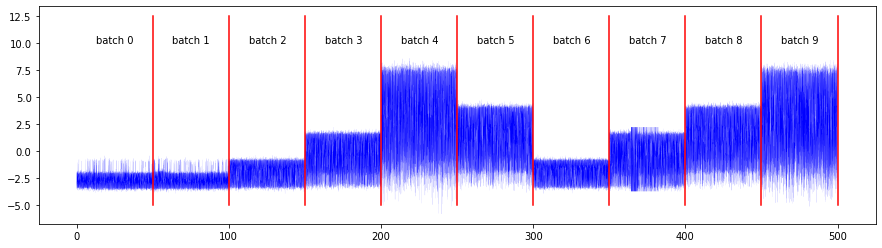

In [38]:
fig, axs = plt.subplots(figsize=(15, 4))
axs.plot(df_train['time'],df_train['remove_drift'], linewidth=.05 ,color='blue')

for batch in df_train['batch'].unique():
    x = float(df_train.loc[df_train['batch']==batch, 'time'][-1:])
    x = np.array([x,x])
    y = np.array([-5,12.5])
    axs.plot(x,y,color='red') 
    axs.annotate(f'batch {batch}', xy = (x[0]-37,10))

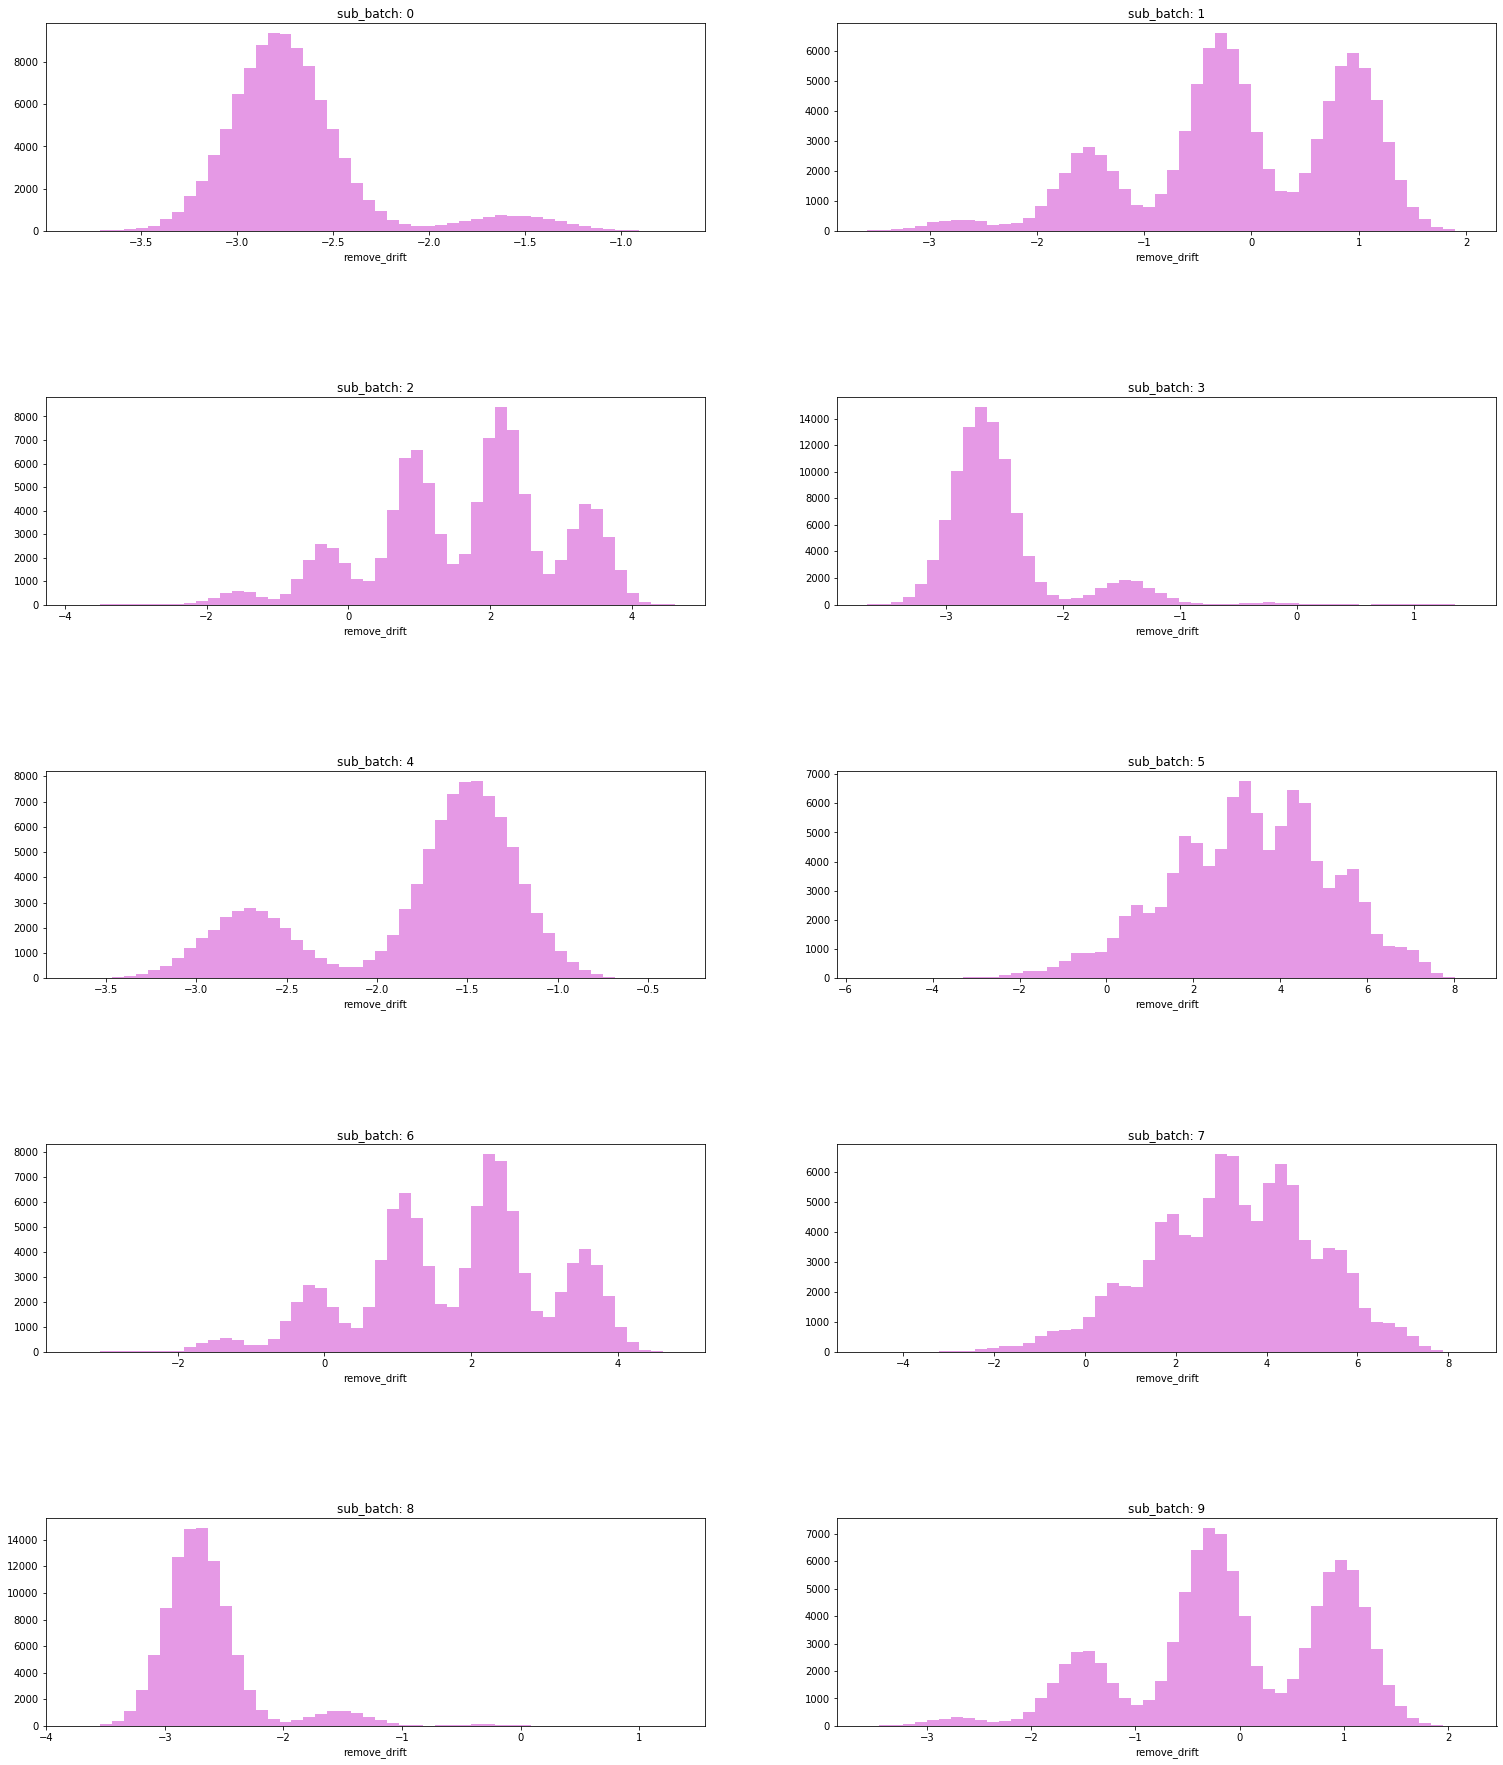

In [39]:
plt.figure(figsize=(26, 22))
plt.subplots_adjust(top=1.2, hspace = 0.8)
for i, b in enumerate(df_test['sub_batch'].unique()):
    if i<10:
        plt.subplot(5, 2, i + 1)
        plt.title(f'sub_batch: {b}')
        batch = df_test.loc[df_test['sub_batch']==b]
        #sns.distplot(batch['open_channels'], kde=False, color="m")
        sns.distplot(batch['remove_drift'], kde=False, color="m")
        plt.grid(False)

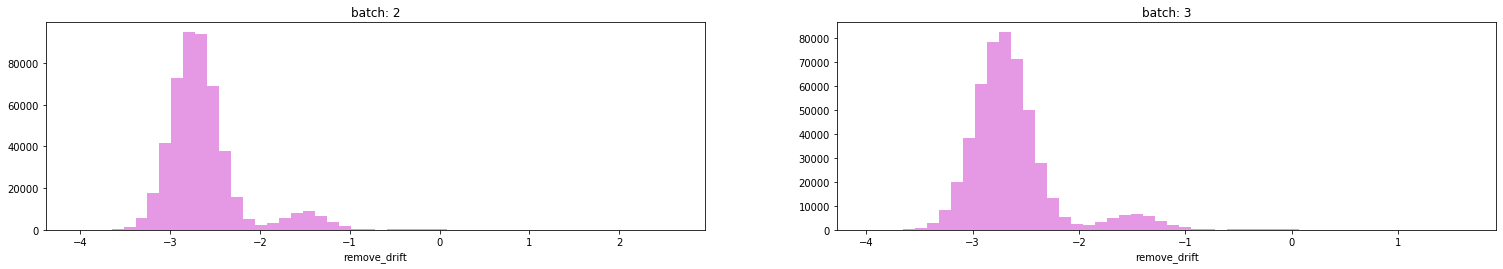

In [40]:
plt.figure(figsize=(26, 22))
plt.subplots_adjust(top=1.2, hspace = 0.8)
for i, b in enumerate(df_test['batch'].unique()):
    if i>1:
        plt.subplot(5, 2, i + 1)
        plt.title(f'batch: {b}')
        batch = df_test.loc[df_test['batch']==b]
        #sns.distplot(batch['open_channels'], kde=False, color="m")
        sns.distplot(batch['remove_drift'], kde=False, color="m")
        plt.grid(False)

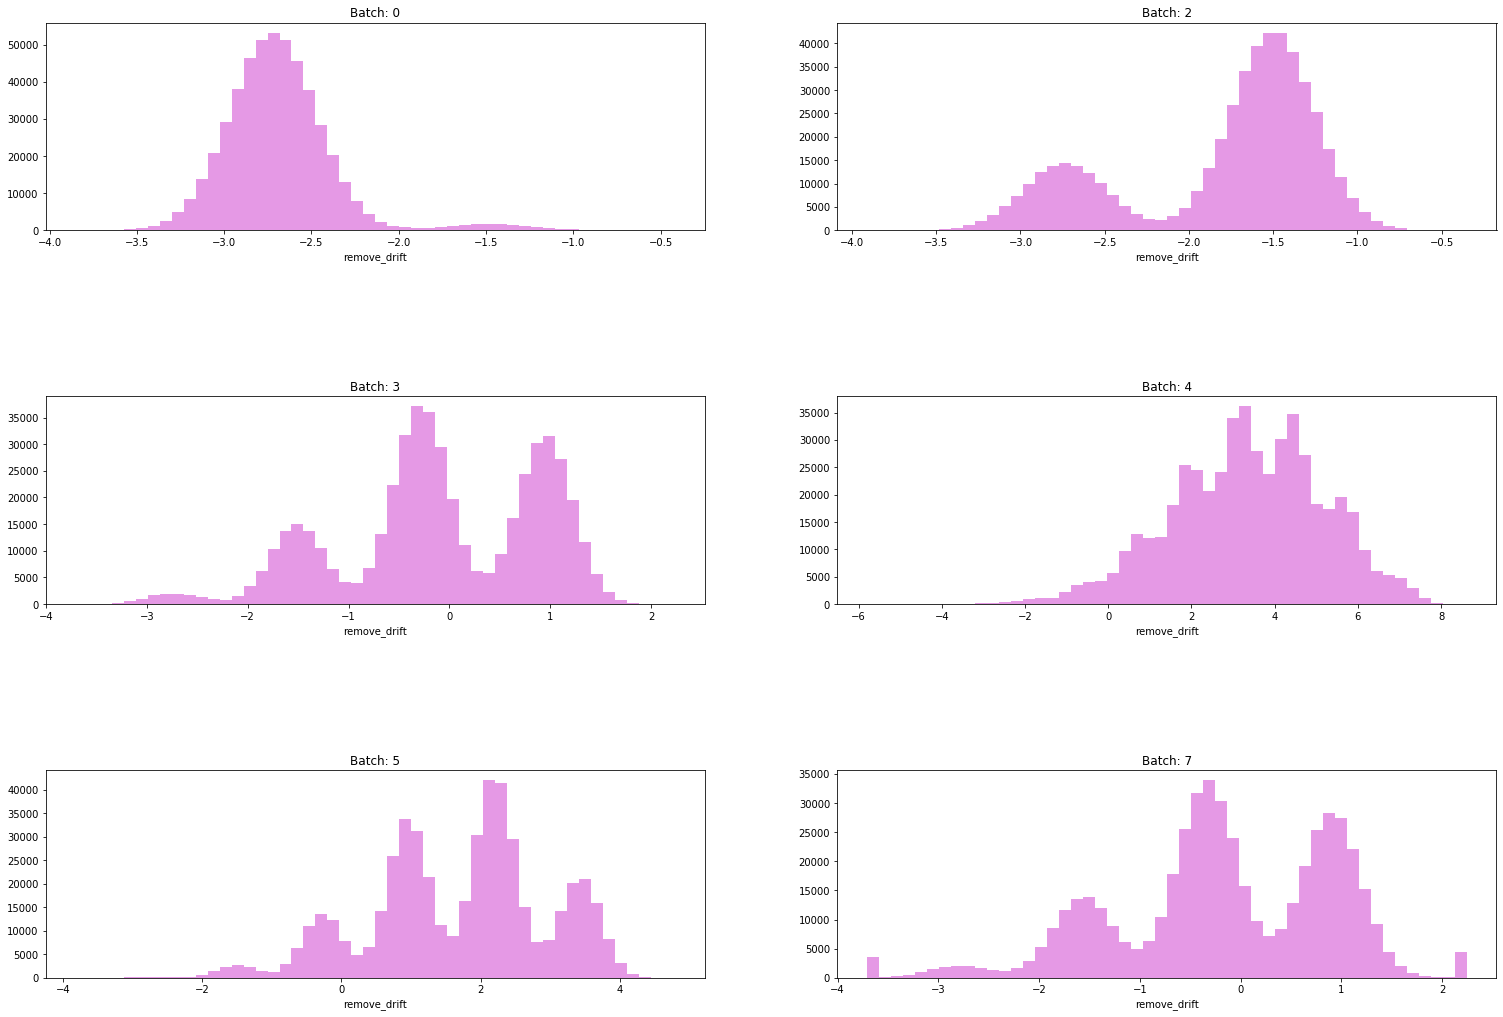

In [41]:
different_batch = [0,2,3,4,5,7]
plt.figure(figsize=(26, 22))
plt.subplots_adjust(top=1.2, hspace = 0.8)
for i, b in enumerate(different_batch):
    plt.subplot(5, 2, i + 1)
    plt.title(f'Batch: {b}')
    batch = df_train.loc[df_train['batch']==b]
    #sns.distplot(batch['open_channels'], kde=False, color="m")
    sns.distplot(batch['remove_drift'], kde=False, color="m")
    plt.grid(False)

In [42]:
sub_batch = [0,1,2,3,4,5,6,7,8,9,2,3]
batch = [0,3,5,0,2,4,5,4,0,3,0,0]
df_gen_data = pd.DataFrame(columns = ['sub_batch_test', 'batch_train'])
df_gen_data['sub_batch_test'] = sub_batch
df_gen_data['batch_train'] = batch

In [43]:
df_gen_data

,sub_batch_test,batch_train
0,0,0
1,1,3
2,2,5
3,3,0
4,4,2
5,5,4
6,6,5
7,7,4
8,8,0
9,9,3


In [44]:
sub_batch_abnormality = [0,3,8,10,11,12,13,14,15,16,17,18,19]
max_ = df_train.loc[df_train['batch']==0]['remove_drift'].max()

for sub_batch in (sub_batch_abnormality):
    df_test.loc[(df_test['sub_batch']==sub_batch)&(df_test['remove_drift']>max_), 'remove_drift'] = max_

## Features

In [45]:
#df_test.to_csv('test_preproc.csv', index = False)
#df_train.to_csv('train_preproc.csv', index = False)
df_test_clear = df_test.copy()
df_train_clear = df_train.copy()

In [46]:
del df_test_clear
del df_train_clear

In [ ]:
#df_test = pd.read_csv('test_preproc.csv')
#df_train = pd.read_csv('test_preproc.csv')
df_test = df_test_clear.copy()
df_train = df_train_clear.copy()

In [46]:
def add_50k_5k_batch (df):
    #add sub_batch_50k numbers
    df['sub_batch_50k'] = 0
    sub_batch_index = [i for i in range(0,5000001,50000)]
    for i in range(len(sub_batch_index)-1):
        df.loc[sub_batch_index[i]:sub_batch_index[i+1]+1,'sub_batch_50k'] = i
    #add sub_batch_5k numbers
    df['sub_batch_5k'] = 0
    sub_batch_index = [i for i in range(0,5000001,5000)]
    for i in range(len(sub_batch_index)-1):
        df.loc[sub_batch_index[i]:sub_batch_index[i+1]+1,'sub_batch_5k'] = i

In [47]:
def batch_features(df):
    
    df['signal_batch_50k_min'] = df.groupby('sub_batch_50k')['remove_drift'].transform('min')
    df['signal_batch_50k_max'] = df.groupby('sub_batch_50k')['remove_drift'].transform('max')
    df['signal_batch_50k_std'] = df.groupby('sub_batch_50k')['remove_drift'].transform('std')
    df['signal_batch_50k_mean'] = df.groupby('sub_batch_50k')['remove_drift'].transform('mean')  
    df['mean_abs_chg_batch_50k'] = df.groupby(['sub_batch_50k'])['remove_drift'].transform(
    lambda x: np.mean(np.abs(np.diff(x)))) # средняя разница между соседними значениями сигналов
    
    df['range_batch_50k'] = df['signal_batch_50k_max'] - df['signal_batch_50k_min']
    df['maxtomin_batch_50k'] = df['signal_batch_50k_max'] / df['signal_batch_50k_min']   
    
    df['signal_batch_5k_min'] = df.groupby('sub_batch_5k')['remove_drift'].transform('min')
    df['signal_batch_5k_max'] = df.groupby('sub_batch_5k')['remove_drift'].transform('max')
    df['signal_batch_5k_std'] = df.groupby('sub_batch_5k')['remove_drift'].transform('std')
    df['signal_batch_5k_mean'] = df.groupby('sub_batch_5k')['remove_drift'].transform('mean')  
    df['mean_abs_chg_batch_5k'] = df.groupby(['sub_batch_5k'])['remove_drift'].transform(
    lambda x: np.mean(np.abs(np.diff(x)))) # средняя разница между соседними значениями сигналов
    
    df['range_batch_5k'] = df['signal_batch_5k_max'] - df['signal_batch_5k_min']
    df['maxtomin_batch_5k'] = df['signal_batch_5k_max'] / df['signal_batch_5k_min']
    
    df['signal_shift+1'] = df.groupby(['sub_batch_50k']).shift(1)['remove_drift']
    df['flag_miss_+1'] = pd.isna(df['signal_shift+1'])
    df['flag_miss_+1'] = np.where(df['flag_miss_+1'], 1, 0)
    
    df['signal_shift-1'] = df.groupby(['sub_batch_50k']).shift(-1)['remove_drift']
    df['flag_miss_-1'] = pd.isna(df['signal_shift-1'])
    df['flag_miss_-1'] = np.where(df['flag_miss_-1'], 1, 0)
    
    df['signal_shift+2'] = df.groupby(['sub_batch_50k']).shift(2)['remove_drift']
    df['flag_miss_+2'] = pd.isna(df['signal_shift+2'])
    df['flag_miss_+2'] = np.where(df['flag_miss_+2'], 1, 0)
    
    df['signal_shift-2'] = df.groupby(['sub_batch_50k']).shift(-2)['remove_drift']    
    df['flag_miss_-2'] = pd.isna(df['signal_shift-2'])
    df['flag_miss_-2'] = np.where(df['flag_miss_-2'], 1, 0)
    
    df.fillna(0, inplace = True)
    
    column_for_dif = ['signal_batch_50k_min','signal_batch_50k_max','signal_batch_50k_std','signal_batch_50k_mean',
                  'signal_batch_5k_min','signal_batch_5k_max','signal_batch_5k_std','signal_batch_5k_mean']
    
    for column in column_for_dif:
        df[f"{column}_dif"] = df[column] - df['remove_drift']
        df[f"{column}_dif_abs"] = np.abs(df[column].abs() - df['remove_drift'].abs())
        
    _, bin_signal = np.histogram(df['remove_drift'], 150)
    df['quant_signal'] = df['remove_drift'].transform(lambda x: bin_signal[np.argmin(np.abs(bin_signal-x))])
    
    df['bin_signal'] = pd.qcut(df['remove_drift'].values, 25, labels=False)
  
    #return df.head()

In [48]:
def rolling_window_train (t_list, win_size = [10, 50, 100, 150, 200, 250, 300]):
    for t in t_list:
        for w in win_size:
            t[f'rolling_window_mean_{w}'] = t['remove_drift'].rolling(w, min_periods = round(w/5)).mean()
            t['flag_miss_mean'] = pd.isna(t[f'rolling_window_mean_{w}'])
            t['flag_miss_mean'] = np.where(t['flag_miss_mean'], 1, 0)
            t['flag_miss_mean'] = t['flag_miss_mean'].astype('int32')
            
            t[f'rolling_window_std_{w}'] = t['remove_drift'].rolling(w, min_periods = round(w/5)).std()
            t[f'flag_miss_std_{w}'] = pd.isna(t[f'rolling_window_std_{w}'])
            t[f'flag_miss_std_{w}'] = np.where(t[f'flag_miss_std_{w}'], 1, 0)
            t[f'flag_miss_std_{w}'] = t[f'flag_miss_std_{w}'].astype('int32')
                        
            t[f'rolling_window_min_{w}'] = t['remove_drift'].rolling(w, min_periods = round(w/5)).min()
            t[f'flag_miss_min_{w}'] = pd.isna(t[f'rolling_window_min_{w}'])
            t[f'flag_miss_min_{w}'] = np.where(t[f'flag_miss_min_{w}'], 1, 0)
            t[f'flag_miss_min_{w}'] = t[f'flag_miss_min_{w}'].astype('int32')
            
            t[f'rolling_window_max_{w}'] = t['remove_drift'].rolling(w, min_periods = round(w/5)).max()
            t[f'flag_miss_max_{w}'] = pd.isna(t[f'rolling_window_max_{w}'])
            t[f'flag_miss_max_{w}'] = np.where(t[f'flag_miss_max_{w}'], 1, 0)
            t[f'flag_miss_max_{w}'] = t[f'flag_miss_max_{w}'].astype('int32')
            
            t[f'maxtomin_rolling_window_{w}'] = t[f'rolling_window_max_{w}'] / t[f'rolling_window_min_{w}']
            t[f'range_rolling_window_{w}'] = t[f'rolling_window_max_{w}'] - t[f'rolling_window_min_{w}']
            t.fillna(0, inplace = True)
            
            column_for_dif = [f'rolling_window_mean_{w}',f'rolling_window_min_{w}',f'rolling_window_max_{w}']
    
            for column in column_for_dif:
                t[f'{column}_dif'] = t[column] - t['remove_drift']
                t[f'{column}_dif_abs'] = np.abs(t[column].abs() - t['remove_drift'].abs())

In [49]:
def rolling_window_test (df, s_batch = 'sub_batch', win_size = [10, 50, 100, 150, 200, 250, 300]):
    for s_b in df[s_batch].unique():
        for w in win_size:
            df.loc[df[s_batch] == s_b, f'rolling_window_mean_{w}'] = df.loc[df[s_batch] == s_b,'remove_drift'].rolling(
                w, min_periods = round(w/5)).mean()
            df.loc[df[s_batch] == s_b, 'flag_miss_mean'] = pd.isna(df.loc[df[s_batch] == s_b, f'rolling_window_mean_{w}'])
            df.loc[df[s_batch] == s_b, 'flag_miss_mean'] = np.where(df.loc[df[s_batch] == s_b, 'flag_miss_mean'], 1, 0)
            df.loc[df[s_batch] == s_b, 'flag_miss_mean'] = df.loc[df[s_batch] == s_b, 'flag_miss_mean'].astype('int32')
            
            df.loc[df[s_batch] == s_b, f'rolling_window_std_{w}'] = df.loc[df[s_batch] == s_b, 'remove_drift'].rolling(
                w, min_periods = round(w/5)).std()
            df.loc[df[s_batch] == s_b, f'flag_miss_std_{w}'] = pd.isna(df.loc[df[s_batch] == s_b,f'rolling_window_std_{w}'])
            df.loc[df[s_batch] == s_b, f'flag_miss_std_{w}'] = np.where( df.loc[df[s_batch] == s_b, f'flag_miss_std_{w}'], 1, 0)
            df.loc[df[s_batch] == s_b, f'flag_miss_std_{w}'] =  df.loc[df[s_batch] == s_b, f'flag_miss_std_{w}'].astype('int32')
                        
            df.loc[df[s_batch] == s_b, f'rolling_window_min_{w}'] =  df.loc[df[s_batch] == s_b, 'remove_drift'].rolling(
                w, min_periods = round(w/5)).min()
            df.loc[df[s_batch] == s_b, f'flag_miss_min_{w}'] = pd.isna(df.loc[df[s_batch] == s_b, f'rolling_window_min_{w}'])
            df.loc[df[s_batch] == s_b, f'flag_miss_min_{w}'] = np.where(df.loc[df[s_batch] == s_b, f'flag_miss_min_{w}'], 1, 0)
            df.loc[df[s_batch] == s_b, f'flag_miss_min_{w}'] = df.loc[df[s_batch] == s_b, f'flag_miss_min_{w}'].astype('int32')
            
            df.loc[df[s_batch] == s_b, f'rolling_window_max_{w}'] = df.loc[df[s_batch] == s_b, 'remove_drift'].rolling(
                w, min_periods = round(w/5)).max()
            df.loc[df[s_batch] == s_b, f'flag_miss_max_{w}'] = pd.isna(df.loc[df[s_batch] == s_b, f'rolling_window_max_{w}'])
            df.loc[df[s_batch] == s_b, f'flag_miss_max_{w}'] = np.where(df.loc[df[s_batch] == s_b, f'flag_miss_max_{w}'], 1, 0)
            df.loc[df[s_batch] == s_b, f'flag_miss_max_{w}'] = df.loc[df[s_batch] == s_b, f'flag_miss_max_{w}'].astype('int32')
            
            
            df.loc[df[s_batch] == s_b, f'maxtomin_rolling_window_{w}'] = df.loc[
                df[s_batch] == s_b, f'rolling_window_max_{w}'] / df.loc[df[s_batch] == s_b, f'rolling_window_min_{w}']
            df.loc[df[s_batch] == s_b, f'range_rolling_window_{w}'] = df.loc[
                df[s_batch] == s_b, f'rolling_window_max_{w}'] - df.loc[df[s_batch] == s_b, f'rolling_window_min_{w}']
            
            df.loc[df[s_batch] == s_b] = df.loc[df[s_batch] == s_b].fillna(0)
            
            column_for_dif = [f'rolling_window_mean_{w}',f'rolling_window_min_{w}',f'rolling_window_max_{w}']
    
            for column in column_for_dif:
                 df.loc[df[s_batch] == s_b, f'{column}_dif'] =  df.loc[
                     df[s_batch] == s_b, column] -  df.loc[df[s_batch] == s_b,'remove_drift']
                 df.loc[df[s_batch] == s_b, f'{column}_dif_abs'] =  np.abs(df.loc[
                     df[s_batch] == s_b, column].abs() -  df.loc[df[s_batch] == s_b,'remove_drift'].abs())

In [50]:
def downcast_dtypes(df):   
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)

In [51]:
add_50k_5k_batch(df_train)

In [52]:
add_50k_5k_batch(df_test)

In [53]:
batch_features(df_train)

In [54]:
batch_features(df_test)

In [55]:
downcast_dtypes(df_train)
downcast_dtypes(df_test)

In [56]:
freq_enc_50k = df_train.groupby('sub_batch_50k')['quant_signal'].value_counts(normalize=True).to_frame()
freq_enc_50k.rename(columns={'quant_signal': 'freq_enc_50k'}, inplace =True)
freq_enc_50k.reset_index(inplace = True)
df_train = pd.merge(df_train, freq_enc_50k, on = ['sub_batch_50k','quant_signal'], how='left')

freq_enc_5k = df_train.groupby('sub_batch_5k')['quant_signal'].value_counts(normalize=True).to_frame()
freq_enc_5k.rename(columns={'quant_signal': 'freq_enc_5k'}, inplace =True)
freq_enc_5k.reset_index(inplace = True)
df_train = pd.merge(df_train, freq_enc_5k, on = ['sub_batch_5k','quant_signal'], how='left')

df_train['signal_on_freq_50k'] = df_train['freq_enc_50k']*df_train['remove_drift']
df_train['signal_on_freq_5k'] = df_train['freq_enc_5k']*df_train['remove_drift']

In [57]:
freq_enc_50k = df_test.groupby('sub_batch_50k')['quant_signal'].value_counts(normalize=True).to_frame()
freq_enc_50k.rename(columns={'quant_signal': 'freq_enc_50k'}, inplace =True)
freq_enc_50k.reset_index(inplace = True)
df_test = pd.merge(df_test, freq_enc_50k, on = ['sub_batch_50k','quant_signal'], how='left')

freq_enc_5k = df_test.groupby('sub_batch_5k')['quant_signal'].value_counts(normalize=True).to_frame()
freq_enc_5k.rename(columns={'quant_signal': 'freq_enc_5k'}, inplace =True)
freq_enc_5k.reset_index(inplace = True)
df_test = pd.merge(df_test, freq_enc_5k, on = ['sub_batch_5k','quant_signal'], how='left')

df_test['signal_on_freq_50k'] = df_test['freq_enc_50k']*df_test['remove_drift']
df_test['signal_on_freq_5k'] = df_test['freq_enc_5k']*df_test['remove_drift']

In [58]:
df_test.drop(columns=['sub_batch_50k','sub_batch_5k'], inplace=True)
df_train.drop(columns=['sub_batch_50k','sub_batch_5k'], inplace=True)

In [59]:
#downcast_dtypes(df_test)
#downcast_dtypes(df_train)

In [60]:
df_train_1 = pd.concat([df_train.loc[df_train['batch']==0], df_train.loc[df_train['batch']==1]])
df_train_2 = pd.concat([df_train.loc[df_train['batch']==2], df_train.loc[df_train['batch']==6]])
df_train_3 = pd.concat([df_train.loc[df_train['batch']==3], df_train.loc[df_train['batch']==7]])
df_train_4 = pd.concat([df_train.loc[df_train['batch']==4], df_train.loc[df_train['batch']==9]])
df_train_5 = pd.concat([df_train.loc[df_train['batch']==5], df_train.loc[df_train['batch']==8]])

In [61]:
train_list = [df_train_1, df_train_2, df_train_3, df_train_4, df_train_5]

In [62]:
rolling_window_train(train_list)

In [63]:
rolling_window_test(df_test)

In [64]:
for train in train_list:
    downcast_dtypes(train)

In [65]:
downcast_dtypes(df_test)

In [66]:
train.head()

,time,signal,open_channels,batch,remove_drift,signal_batch_50k_min,signal_batch_50k_max,signal_batch_50k_std,signal_batch_50k_mean,mean_abs_chg_batch_50k,...,rolling_window_max_300,flag_miss_max_300,maxtomin_rolling_window_300,range_rolling_window_300,rolling_window_mean_300_dif,rolling_window_mean_300_dif_abs,rolling_window_min_300_dif,rolling_window_min_300_dif_abs,rolling_window_max_300_dif,rolling_window_max_300_dif_abs
2500000,250.000107,2.8555,5,5,2.8555,-3.6139,4.7282,1.282807,1.699518,0.728617,...,0.0,1,0.0,0.0,-2.8555,2.8555,-2.8555,2.8555,-2.8555,2.8555
2500001,250.000198,3.0907,5,5,3.0907,-3.6139,4.7282,1.282807,1.699518,0.728617,...,0.0,1,0.0,0.0,-3.0907,3.0907,-3.0907,3.0907,-3.0907,3.0907
2500002,250.000305,3.5277,5,5,3.5277,-3.6139,4.7282,1.282807,1.699518,0.728617,...,0.0,1,0.0,0.0,-3.5277,3.5277,-3.5277,3.5277,-3.5277,3.5277
2500003,250.000397,3.9822,5,5,3.9822,-3.6139,4.7282,1.282807,1.699518,0.728617,...,0.0,1,0.0,0.0,-3.9822,3.9822,-3.9822,3.9822,-3.9822,3.9822
2500004,250.000504,3.3368,5,5,3.3368,-3.6139,4.7282,1.282807,1.699518,0.728617,...,0.0,1,0.0,0.0,-3.3368,3.3368,-3.3368,3.3368,-3.3368,3.3368


In [67]:
df_test.head()

,time,signal,remove_drift,batch,sub_batch,signal_batch_50k_min,signal_batch_50k_max,signal_batch_50k_std,signal_batch_50k_mean,mean_abs_chg_batch_50k,...,rolling_window_max_300,flag_miss_max_300,maxtomin_rolling_window_300,range_rolling_window_300,rolling_window_mean_300_dif,rolling_window_mean_300_dif_abs,rolling_window_min_300_dif,rolling_window_min_300_dif_abs,rolling_window_max_300_dif,rolling_window_max_300_dif_abs
0,500.000092,-2.6498,-2.649800,0,0,-3.840342,-0.718572,0.360511,-2.698807,0.284248,...,0.0,1,0.0,0.0,2.649800,2.649800,2.649800,2.649800,2.649800,2.649800
1,500.000214,-2.8494,-2.849435,0,0,-3.840342,-0.718572,0.360511,-2.698807,0.284248,...,0.0,1,0.0,0.0,2.849435,2.849435,2.849435,2.849435,2.849435,2.849435
2,500.000305,-2.8600,-2.860070,0,0,-3.840342,-0.718572,0.360511,-2.698807,0.284248,...,0.0,1,0.0,0.0,2.860070,2.860070,2.860070,2.860070,2.860070,2.860070
3,500.000397,-2.4350,-2.435105,0,0,-3.840342,-0.718572,0.360511,-2.698807,0.284248,...,0.0,1,0.0,0.0,2.435105,2.435105,2.435105,2.435105,2.435105,2.435105
4,500.000488,-2.6155,-2.615640,0,0,-3.840342,-0.718572,0.360511,-2.698807,0.284248,...,0.0,1,0.0,0.0,2.615640,2.615640,2.615640,2.615640,2.615640,2.615640


## Mean encoding don't RUN

In [ ]:

train_list_new = []
for j in range(5):
    kf = KFold(n_splits = 5, shuffle=False)
    train, val = zip(*kf.split(train_list[j]))
    
    for train_index, val_index, i in zip(train, val, range(5)):    
        train_open_channels_mean_bin = train_list[j].iloc[train_index].groupby('quant_signal').open_channels.mean()
        
        val_data = train_list[j].iloc[val_index]
        
        val_data['mean_open_channels'] = val_data['quant_signal'].map(train_open_channels_mean_bin)   
        
        if i == 0:
            data = val_data.copy()
        else:
            data = pd.concat([data,val_data])
    train_list_new.append(data)

## Rank transform don't run

In [ ]:
for train in train_list:
    train['rank_quant_signal'] = train['quant_signal'].rank(method='max')

In [ ]:
for train in train_list_new:
        train['std_signal_bin'] = train.groupby('bin_signal')['remove_drift'].transform('std')
        train['mean_signal_bin'] = train.groupby('bin_signal')['remove_drift'].transform('mean')

## Modeling

In [68]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.externals import joblib
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Переходи на этап загрузки моделей

In [69]:
X = train_list[0].iloc[:, 4:].values
y = train_list[0].iloc[:, 2:3].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model_1 = CatBoostClassifier(iterations=600, 
                           learning_rate = 0.05,
                           bootstrap_type = 'Bernoulli',
                           subsample = 0.4,
                           grow_policy = 'Lossguide',
                           max_leaves = 40,
                           depth = 12) 
model_1.fit(X_train, y_train)
y_pred = model_1.predict(X_test) 
print(f'f1_macro fourth cat model 1: {f1_score(y_test, y_pred, average="macro")}')

0:	learn: 0.5024012	total: 395ms	remaining: 3m 56s
1:	learn: 0.3876002	total: 604ms	remaining: 3m
2:	learn: 0.2998298	total: 820ms	remaining: 2m 43s
3:	learn: 0.2327483	total: 1.02s	remaining: 2m 32s
4:	learn: 0.1684448	total: 1.28s	remaining: 2m 32s
5:	learn: 0.1128651	total: 1.49s	remaining: 2m 27s
6:	learn: 0.0834598	total: 1.73s	remaining: 2m 26s
7:	learn: 0.0605377	total: 1.97s	remaining: 2m 25s
8:	learn: 0.0467576	total: 2.19s	remaining: 2m 23s
9:	learn: 0.0348277	total: 2.4s	remaining: 2m 21s
10:	learn: 0.0255731	total: 2.63s	remaining: 2m 21s
11:	learn: 0.0195490	total: 2.87s	remaining: 2m 20s
12:	learn: 0.0156308	total: 3.08s	remaining: 2m 18s
13:	learn: 0.0123215	total: 3.29s	remaining: 2m 17s
14:	learn: 0.0101038	total: 3.5s	remaining: 2m 16s
15:	learn: 0.0083691	total: 3.72s	remaining: 2m 15s
16:	learn: 0.0070485	total: 3.94s	remaining: 2m 15s
17:	learn: 0.0062083	total: 4.15s	remaining: 2m 14s
18:	learn: 0.0054316	total: 4.36s	remaining: 2m 13s
19:	learn: 0.0048791	total: 

159:	learn: 0.0005542	total: 36.9s	remaining: 1m 41s
160:	learn: 0.0005508	total: 37.1s	remaining: 1m 41s
161:	learn: 0.0005489	total: 37.3s	remaining: 1m 40s
162:	learn: 0.0005462	total: 37.6s	remaining: 1m 40s
163:	learn: 0.0005433	total: 37.8s	remaining: 1m 40s
164:	learn: 0.0005407	total: 38.1s	remaining: 1m 40s
165:	learn: 0.0005368	total: 38.3s	remaining: 1m 40s
166:	learn: 0.0005341	total: 38.5s	remaining: 1m 39s
167:	learn: 0.0005310	total: 38.7s	remaining: 1m 39s
168:	learn: 0.0005275	total: 39s	remaining: 1m 39s
169:	learn: 0.0005257	total: 39.2s	remaining: 1m 39s
170:	learn: 0.0005217	total: 39.4s	remaining: 1m 38s
171:	learn: 0.0005201	total: 39.7s	remaining: 1m 38s
172:	learn: 0.0005186	total: 39.9s	remaining: 1m 38s
173:	learn: 0.0005171	total: 40.1s	remaining: 1m 38s
174:	learn: 0.0005150	total: 40.3s	remaining: 1m 37s
175:	learn: 0.0005127	total: 40.6s	remaining: 1m 37s
176:	learn: 0.0005105	total: 40.8s	remaining: 1m 37s
177:	learn: 0.0005075	total: 41s	remaining: 1m 3

315:	learn: 0.0002879	total: 1m 13s	remaining: 1m 5s
316:	learn: 0.0002871	total: 1m 13s	remaining: 1m 5s
317:	learn: 0.0002862	total: 1m 13s	remaining: 1m 5s
318:	learn: 0.0002849	total: 1m 14s	remaining: 1m 5s
319:	learn: 0.0002836	total: 1m 14s	remaining: 1m 4s
320:	learn: 0.0002831	total: 1m 14s	remaining: 1m 4s
321:	learn: 0.0002812	total: 1m 14s	remaining: 1m 4s
322:	learn: 0.0002803	total: 1m 14s	remaining: 1m 4s
323:	learn: 0.0002796	total: 1m 15s	remaining: 1m 4s
324:	learn: 0.0002781	total: 1m 15s	remaining: 1m 3s
325:	learn: 0.0002765	total: 1m 15s	remaining: 1m 3s
326:	learn: 0.0002752	total: 1m 15s	remaining: 1m 3s
327:	learn: 0.0002741	total: 1m 16s	remaining: 1m 3s
328:	learn: 0.0002730	total: 1m 16s	remaining: 1m 2s
329:	learn: 0.0002720	total: 1m 16s	remaining: 1m 2s
330:	learn: 0.0002711	total: 1m 16s	remaining: 1m 2s
331:	learn: 0.0002693	total: 1m 17s	remaining: 1m 2s
332:	learn: 0.0002683	total: 1m 17s	remaining: 1m 1s
333:	learn: 0.0002672	total: 1m 17s	remaining:

471:	learn: 0.0001646	total: 1m 49s	remaining: 29.7s
472:	learn: 0.0001639	total: 1m 49s	remaining: 29.5s
473:	learn: 0.0001633	total: 1m 50s	remaining: 29.3s
474:	learn: 0.0001629	total: 1m 50s	remaining: 29s
475:	learn: 0.0001627	total: 1m 50s	remaining: 28.8s
476:	learn: 0.0001619	total: 1m 50s	remaining: 28.6s
477:	learn: 0.0001614	total: 1m 50s	remaining: 28.3s
478:	learn: 0.0001606	total: 1m 51s	remaining: 28.1s
479:	learn: 0.0001600	total: 1m 51s	remaining: 27.8s
480:	learn: 0.0001587	total: 1m 51s	remaining: 27.6s
481:	learn: 0.0001584	total: 1m 51s	remaining: 27.4s
482:	learn: 0.0001579	total: 1m 52s	remaining: 27.1s
483:	learn: 0.0001571	total: 1m 52s	remaining: 26.9s
484:	learn: 0.0001569	total: 1m 52s	remaining: 26.7s
485:	learn: 0.0001563	total: 1m 52s	remaining: 26.4s
486:	learn: 0.0001560	total: 1m 53s	remaining: 26.2s
487:	learn: 0.0001557	total: 1m 53s	remaining: 26s
488:	learn: 0.0001550	total: 1m 53s	remaining: 25.8s
489:	learn: 0.0001543	total: 1m 53s	remaining: 25.

In [70]:
X = train_list[1].iloc[:, 4:].values
y = train_list[1].iloc[:, 2:3].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model_2 = CatBoostClassifier(iterations=600, 
                           learning_rate = 0.05,
                           bootstrap_type = 'Bernoulli',
                           subsample = 0.4,
                           grow_policy = 'Lossguide',
                           max_leaves = 40,
                           depth = 12) 
model_2.fit(X_train, y_train) 
y_pred = model_2.predict(X_test)
print(f'f1_macro second cat model 2: {f1_score(y_test, y_pred, average="macro")}')

0:	learn: 0.5517969	total: 284ms	remaining: 2m 50s
1:	learn: 0.4241586	total: 519ms	remaining: 2m 35s
2:	learn: 0.3385525	total: 765ms	remaining: 2m 32s
3:	learn: 0.2653869	total: 1.04s	remaining: 2m 34s
4:	learn: 0.1988578	total: 1.3s	remaining: 2m 35s
5:	learn: 0.1530985	total: 1.55s	remaining: 2m 33s
6:	learn: 0.1194571	total: 1.8s	remaining: 2m 32s
7:	learn: 0.0934999	total: 2.04s	remaining: 2m 30s
8:	learn: 0.0767727	total: 2.29s	remaining: 2m 30s
9:	learn: 0.0617982	total: 2.54s	remaining: 2m 29s
10:	learn: 0.0511356	total: 2.77s	remaining: 2m 28s
11:	learn: 0.0430564	total: 3.02s	remaining: 2m 27s
12:	learn: 0.0369631	total: 3.25s	remaining: 2m 26s
13:	learn: 0.0325029	total: 3.49s	remaining: 2m 25s
14:	learn: 0.0287229	total: 3.72s	remaining: 2m 24s
15:	learn: 0.0255203	total: 3.94s	remaining: 2m 23s
16:	learn: 0.0228667	total: 4.17s	remaining: 2m 22s
17:	learn: 0.0207109	total: 4.39s	remaining: 2m 22s
18:	learn: 0.0191234	total: 4.63s	remaining: 2m 21s
19:	learn: 0.0174372	tot

160:	learn: 0.0058788	total: 35.1s	remaining: 1m 35s
161:	learn: 0.0058716	total: 35.3s	remaining: 1m 35s
162:	learn: 0.0058646	total: 35.5s	remaining: 1m 35s
163:	learn: 0.0058565	total: 35.7s	remaining: 1m 34s
164:	learn: 0.0058496	total: 36s	remaining: 1m 34s
165:	learn: 0.0058431	total: 36.2s	remaining: 1m 34s
166:	learn: 0.0058362	total: 36.4s	remaining: 1m 34s
167:	learn: 0.0058313	total: 36.5s	remaining: 1m 33s
168:	learn: 0.0058165	total: 36.8s	remaining: 1m 33s
169:	learn: 0.0058107	total: 37s	remaining: 1m 33s
170:	learn: 0.0058035	total: 37.2s	remaining: 1m 33s
171:	learn: 0.0057984	total: 37.4s	remaining: 1m 33s
172:	learn: 0.0057911	total: 37.6s	remaining: 1m 32s
173:	learn: 0.0057818	total: 37.8s	remaining: 1m 32s
174:	learn: 0.0057745	total: 38.1s	remaining: 1m 32s
175:	learn: 0.0057700	total: 38.3s	remaining: 1m 32s
176:	learn: 0.0057652	total: 38.5s	remaining: 1m 31s
177:	learn: 0.0057585	total: 38.7s	remaining: 1m 31s
178:	learn: 0.0057510	total: 38.9s	remaining: 1m 3

317:	learn: 0.0049400	total: 1m 7s	remaining: 59.8s
318:	learn: 0.0049329	total: 1m 7s	remaining: 59.6s
319:	learn: 0.0049278	total: 1m 7s	remaining: 59.3s
320:	learn: 0.0049210	total: 1m 8s	remaining: 59.1s
321:	learn: 0.0049164	total: 1m 8s	remaining: 58.9s
322:	learn: 0.0049137	total: 1m 8s	remaining: 58.7s
323:	learn: 0.0049095	total: 1m 8s	remaining: 58.5s
324:	learn: 0.0049039	total: 1m 8s	remaining: 58.3s
325:	learn: 0.0048957	total: 1m 9s	remaining: 58s
326:	learn: 0.0048903	total: 1m 9s	remaining: 57.8s
327:	learn: 0.0048862	total: 1m 9s	remaining: 57.6s
328:	learn: 0.0048798	total: 1m 9s	remaining: 57.4s
329:	learn: 0.0048748	total: 1m 9s	remaining: 57.1s
330:	learn: 0.0048694	total: 1m 10s	remaining: 56.9s
331:	learn: 0.0048645	total: 1m 10s	remaining: 56.7s
332:	learn: 0.0048610	total: 1m 10s	remaining: 56.5s
333:	learn: 0.0048565	total: 1m 10s	remaining: 56.3s
334:	learn: 0.0048495	total: 1m 10s	remaining: 56.1s
335:	learn: 0.0048452	total: 1m 11s	remaining: 55.9s
336:	lea

474:	learn: 0.0042202	total: 1m 39s	remaining: 26.1s
475:	learn: 0.0042174	total: 1m 39s	remaining: 25.9s
476:	learn: 0.0042133	total: 1m 39s	remaining: 25.7s
477:	learn: 0.0042102	total: 1m 39s	remaining: 25.5s
478:	learn: 0.0042073	total: 1m 40s	remaining: 25.3s
479:	learn: 0.0042027	total: 1m 40s	remaining: 25.1s
480:	learn: 0.0041973	total: 1m 40s	remaining: 24.9s
481:	learn: 0.0041938	total: 1m 40s	remaining: 24.6s
482:	learn: 0.0041910	total: 1m 40s	remaining: 24.4s
483:	learn: 0.0041860	total: 1m 41s	remaining: 24.2s
484:	learn: 0.0041825	total: 1m 41s	remaining: 24s
485:	learn: 0.0041794	total: 1m 41s	remaining: 23.8s
486:	learn: 0.0041747	total: 1m 41s	remaining: 23.6s
487:	learn: 0.0041712	total: 1m 41s	remaining: 23.4s
488:	learn: 0.0041658	total: 1m 42s	remaining: 23.2s
489:	learn: 0.0041632	total: 1m 42s	remaining: 23s
490:	learn: 0.0041579	total: 1m 42s	remaining: 22.8s
491:	learn: 0.0041551	total: 1m 42s	remaining: 22.5s
492:	learn: 0.0041531	total: 1m 42s	remaining: 22.

In [71]:
X = train_list[2].iloc[:, 4:].values
y = train_list[2].iloc[:, 2:3].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model_3 = CatBoostClassifier(iterations=600, 
                           learning_rate = 0.05,
                           bootstrap_type = 'Bernoulli',
                           subsample = 0.4,
                           grow_policy = 'Lossguide',
                           max_leaves = 40,
                           depth = 12)
model_3.fit(X_train, y_train) 
y_pred = model_3.predict(X_test)
print(f'f1_macro third cat model 3: {f1_score(y_test, y_pred, average="macro")}')

0:	learn: 1.2517539	total: 689ms	remaining: 6m 52s
1:	learn: 1.1409245	total: 1.36s	remaining: 6m 47s
2:	learn: 1.0473789	total: 2.03s	remaining: 6m 44s
3:	learn: 0.9668939	total: 2.68s	remaining: 6m 39s
4:	learn: 0.8968449	total: 3.32s	remaining: 6m 35s
5:	learn: 0.8349508	total: 3.99s	remaining: 6m 35s
6:	learn: 0.7798409	total: 4.67s	remaining: 6m 35s
7:	learn: 0.7307032	total: 5.34s	remaining: 6m 35s
8:	learn: 0.6860126	total: 5.99s	remaining: 6m 33s
9:	learn: 0.6455734	total: 6.61s	remaining: 6m 29s
10:	learn: 0.6084010	total: 7.26s	remaining: 6m 29s
11:	learn: 0.5746614	total: 7.95s	remaining: 6m 29s
12:	learn: 0.5437224	total: 8.64s	remaining: 6m 30s
13:	learn: 0.5150257	total: 9.31s	remaining: 6m 29s
14:	learn: 0.4887689	total: 9.99s	remaining: 6m 29s
15:	learn: 0.4644477	total: 10.7s	remaining: 6m 28s
16:	learn: 0.4419372	total: 11.3s	remaining: 6m 28s
17:	learn: 0.4209747	total: 12s	remaining: 6m 27s
18:	learn: 0.4016357	total: 12.7s	remaining: 6m 27s
19:	learn: 0.3830819	tot

158:	learn: 0.0676948	total: 1m 21s	remaining: 3m 46s
159:	learn: 0.0676727	total: 1m 21s	remaining: 3m 45s
160:	learn: 0.0676429	total: 1m 22s	remaining: 3m 43s
161:	learn: 0.0676344	total: 1m 22s	remaining: 3m 42s
162:	learn: 0.0675361	total: 1m 22s	remaining: 3m 41s
163:	learn: 0.0675235	total: 1m 22s	remaining: 3m 40s
164:	learn: 0.0674365	total: 1m 23s	remaining: 3m 39s
165:	learn: 0.0673817	total: 1m 23s	remaining: 3m 38s
166:	learn: 0.0673761	total: 1m 23s	remaining: 3m 37s
167:	learn: 0.0672991	total: 1m 24s	remaining: 3m 36s
168:	learn: 0.0672261	total: 1m 24s	remaining: 3m 35s
169:	learn: 0.0672192	total: 1m 24s	remaining: 3m 34s
170:	learn: 0.0671703	total: 1m 24s	remaining: 3m 33s
171:	learn: 0.0671494	total: 1m 25s	remaining: 3m 32s
172:	learn: 0.0671400	total: 1m 25s	remaining: 3m 31s
173:	learn: 0.0671014	total: 1m 25s	remaining: 3m 30s
174:	learn: 0.0670959	total: 1m 26s	remaining: 3m 29s
175:	learn: 0.0670635	total: 1m 26s	remaining: 3m 27s
176:	learn: 0.0670540	total:

311:	learn: 0.0642114	total: 2m 3s	remaining: 1m 53s
312:	learn: 0.0642016	total: 2m 3s	remaining: 1m 53s
313:	learn: 0.0641942	total: 2m 3s	remaining: 1m 52s
314:	learn: 0.0641823	total: 2m 4s	remaining: 1m 52s
315:	learn: 0.0641667	total: 2m 4s	remaining: 1m 51s
316:	learn: 0.0641596	total: 2m 4s	remaining: 1m 51s
317:	learn: 0.0641509	total: 2m 4s	remaining: 1m 50s
318:	learn: 0.0641435	total: 2m 5s	remaining: 1m 50s
319:	learn: 0.0641072	total: 2m 5s	remaining: 1m 49s
320:	learn: 0.0640998	total: 2m 5s	remaining: 1m 49s
321:	learn: 0.0640949	total: 2m 6s	remaining: 1m 48s
322:	learn: 0.0640852	total: 2m 6s	remaining: 1m 48s
323:	learn: 0.0640780	total: 2m 6s	remaining: 1m 47s
324:	learn: 0.0640684	total: 2m 6s	remaining: 1m 47s
325:	learn: 0.0640516	total: 2m 7s	remaining: 1m 46s
326:	learn: 0.0640225	total: 2m 7s	remaining: 1m 46s
327:	learn: 0.0640032	total: 2m 7s	remaining: 1m 45s
328:	learn: 0.0639736	total: 2m 7s	remaining: 1m 45s
329:	learn: 0.0639686	total: 2m 8s	remaining: 

465:	learn: 0.0622919	total: 2m 44s	remaining: 47.4s
466:	learn: 0.0622822	total: 2m 45s	remaining: 47s
467:	learn: 0.0622751	total: 2m 45s	remaining: 46.6s
468:	learn: 0.0622682	total: 2m 45s	remaining: 46.3s
469:	learn: 0.0622620	total: 2m 45s	remaining: 45.9s
470:	learn: 0.0622532	total: 2m 46s	remaining: 45.5s
471:	learn: 0.0622446	total: 2m 46s	remaining: 45.1s
472:	learn: 0.0622284	total: 2m 46s	remaining: 44.8s
473:	learn: 0.0622218	total: 2m 46s	remaining: 44.4s
474:	learn: 0.0622150	total: 2m 47s	remaining: 44s
475:	learn: 0.0622065	total: 2m 47s	remaining: 43.6s
476:	learn: 0.0621887	total: 2m 47s	remaining: 43.3s
477:	learn: 0.0621739	total: 2m 48s	remaining: 42.9s
478:	learn: 0.0621645	total: 2m 48s	remaining: 42.5s
479:	learn: 0.0621583	total: 2m 48s	remaining: 42.1s
480:	learn: 0.0621366	total: 2m 48s	remaining: 41.8s
481:	learn: 0.0621297	total: 2m 49s	remaining: 41.4s
482:	learn: 0.0621223	total: 2m 49s	remaining: 41s
483:	learn: 0.0621149	total: 2m 49s	remaining: 40.7s

In [72]:
X = train_list[4].iloc[:, 4:].values
y = train_list[4].iloc[:, 2:3].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model_5 = CatBoostClassifier(iterations=600, 
                           learning_rate = 0.1,
                           bootstrap_type = 'Bernoulli',
                           subsample = 0.4,
                           grow_policy = 'Lossguide',
                           max_leaves = 40,
                           depth = 12) 
model_5.fit(X_train, y_train) 
y_pred = model_5.predict(X_test) 
print(f'f1_macro fifth cat model 5: {f1_score(y_test, y_pred, average="macro")}')

0:	learn: 1.3533836	total: 887ms	remaining: 8m 51s
1:	learn: 1.1047921	total: 1.72s	remaining: 8m 34s
2:	learn: 0.9318392	total: 2.54s	remaining: 8m 25s
3:	learn: 0.8031024	total: 3.36s	remaining: 8m 20s
4:	learn: 0.7019063	total: 4.2s	remaining: 8m 19s
5:	learn: 0.6194176	total: 5.05s	remaining: 8m 19s
6:	learn: 0.5503041	total: 5.85s	remaining: 8m 15s
7:	learn: 0.4924157	total: 6.69s	remaining: 8m 15s
8:	learn: 0.4431204	total: 7.54s	remaining: 8m 14s
9:	learn: 0.4009249	total: 8.41s	remaining: 8m 16s
10:	learn: 0.3645609	total: 9.28s	remaining: 8m 16s
11:	learn: 0.3328643	total: 10.1s	remaining: 8m 15s
12:	learn: 0.3047377	total: 11s	remaining: 8m 15s
13:	learn: 0.2805478	total: 11.8s	remaining: 8m 14s
14:	learn: 0.2589772	total: 12.6s	remaining: 8m 11s
15:	learn: 0.2400710	total: 13.5s	remaining: 8m 11s
16:	learn: 0.2229691	total: 14.3s	remaining: 8m 11s
17:	learn: 0.2077067	total: 15.2s	remaining: 8m 10s
18:	learn: 0.1944166	total: 16s	remaining: 8m 10s
19:	learn: 0.1824320	total:

158:	learn: 0.0633383	total: 1m 17s	remaining: 3m 34s
159:	learn: 0.0633153	total: 1m 17s	remaining: 3m 33s
160:	learn: 0.0632902	total: 1m 17s	remaining: 3m 32s
161:	learn: 0.0632848	total: 1m 18s	remaining: 3m 31s
162:	learn: 0.0632777	total: 1m 18s	remaining: 3m 30s
163:	learn: 0.0632183	total: 1m 18s	remaining: 3m 29s
164:	learn: 0.0631999	total: 1m 19s	remaining: 3m 28s
165:	learn: 0.0631878	total: 1m 19s	remaining: 3m 28s
166:	learn: 0.0631711	total: 1m 19s	remaining: 3m 27s
167:	learn: 0.0631658	total: 1m 20s	remaining: 3m 26s
168:	learn: 0.0631521	total: 1m 20s	remaining: 3m 25s
169:	learn: 0.0631384	total: 1m 20s	remaining: 3m 24s
170:	learn: 0.0631166	total: 1m 21s	remaining: 3m 23s
171:	learn: 0.0631003	total: 1m 21s	remaining: 3m 23s
172:	learn: 0.0630748	total: 1m 22s	remaining: 3m 22s
173:	learn: 0.0630660	total: 1m 22s	remaining: 3m 21s
174:	learn: 0.0630597	total: 1m 22s	remaining: 3m 20s
175:	learn: 0.0630316	total: 1m 23s	remaining: 3m 19s
176:	learn: 0.0630181	total:

312:	learn: 0.0614451	total: 2m 8s	remaining: 1m 58s
313:	learn: 0.0614185	total: 2m 9s	remaining: 1m 57s
314:	learn: 0.0614131	total: 2m 9s	remaining: 1m 57s
315:	learn: 0.0614055	total: 2m 9s	remaining: 1m 56s
316:	learn: 0.0613808	total: 2m 10s	remaining: 1m 56s
317:	learn: 0.0613749	total: 2m 10s	remaining: 1m 55s
318:	learn: 0.0613692	total: 2m 10s	remaining: 1m 55s
319:	learn: 0.0613667	total: 2m 11s	remaining: 1m 54s
320:	learn: 0.0613449	total: 2m 11s	remaining: 1m 54s
321:	learn: 0.0613348	total: 2m 11s	remaining: 1m 53s
322:	learn: 0.0613298	total: 2m 12s	remaining: 1m 53s
323:	learn: 0.0613180	total: 2m 12s	remaining: 1m 52s
324:	learn: 0.0613099	total: 2m 12s	remaining: 1m 52s
325:	learn: 0.0613040	total: 2m 13s	remaining: 1m 52s
326:	learn: 0.0612992	total: 2m 13s	remaining: 1m 51s
327:	learn: 0.0612905	total: 2m 13s	remaining: 1m 51s
328:	learn: 0.0612837	total: 2m 14s	remaining: 1m 50s
329:	learn: 0.0612760	total: 2m 14s	remaining: 1m 50s
330:	learn: 0.0612662	total: 2m 

465:	learn: 0.0601088	total: 3m	remaining: 52s
466:	learn: 0.0601050	total: 3m 1s	remaining: 51.6s
467:	learn: 0.0601030	total: 3m 1s	remaining: 51.2s
468:	learn: 0.0600923	total: 3m 1s	remaining: 50.8s
469:	learn: 0.0600895	total: 3m 2s	remaining: 50.3s
470:	learn: 0.0600814	total: 3m 2s	remaining: 50s
471:	learn: 0.0600778	total: 3m 2s	remaining: 49.6s
472:	learn: 0.0600723	total: 3m 3s	remaining: 49.2s
473:	learn: 0.0600657	total: 3m 3s	remaining: 48.8s
474:	learn: 0.0600632	total: 3m 3s	remaining: 48.3s
475:	learn: 0.0600535	total: 3m 4s	remaining: 47.9s
476:	learn: 0.0600481	total: 3m 4s	remaining: 47.5s
477:	learn: 0.0600411	total: 3m 4s	remaining: 47.1s
478:	learn: 0.0600338	total: 3m 5s	remaining: 46.8s
479:	learn: 0.0600318	total: 3m 5s	remaining: 46.4s
480:	learn: 0.0600289	total: 3m 5s	remaining: 46s
481:	learn: 0.0600264	total: 3m 6s	remaining: 45.5s
482:	learn: 0.0600239	total: 3m 6s	remaining: 45.1s
483:	learn: 0.0600133	total: 3m 6s	remaining: 44.7s
484:	learn: 0.0600089

In [73]:
X = train_list[3].iloc[:, 4:].values
y = train_list[3].iloc[:, 2:3].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model_4 = CatBoostClassifier(iterations=600, 
                           learning_rate = 0.05,
                           bootstrap_type = 'Bernoulli',
                           subsample = 0.4,
                           grow_policy = 'Lossguide',
                           max_leaves = 40,
                           depth = 14)
model_4.fit(X_train, y_train) 
y_pred_cat = model_4.predict(X_test) 
print(f'f1_macro fourth cat model 4: {f1_score(y_test, y_pred_cat, average="macro")}')

0:	learn: 2.0262982	total: 1.3s	remaining: 13m 2s
1:	learn: 1.7942856	total: 2.51s	remaining: 12m 30s
2:	learn: 1.6237285	total: 3.77s	remaining: 12m 30s
3:	learn: 1.4902842	total: 4.96s	remaining: 12m 18s
4:	learn: 1.3809053	total: 6.2s	remaining: 12m 17s
5:	learn: 1.2887183	total: 7.46s	remaining: 12m 18s
6:	learn: 1.2084693	total: 8.73s	remaining: 12m 19s
7:	learn: 1.1387366	total: 9.97s	remaining: 12m 18s
8:	learn: 1.0775844	total: 11.2s	remaining: 12m 15s
9:	learn: 1.0226535	total: 12.4s	remaining: 12m 9s
10:	learn: 0.9743179	total: 13.6s	remaining: 12m 6s
11:	learn: 0.9298984	total: 14.8s	remaining: 12m 6s
12:	learn: 0.8892422	total: 16s	remaining: 12m 2s
13:	learn: 0.8524657	total: 17.2s	remaining: 12m
14:	learn: 0.8174197	total: 18.5s	remaining: 12m
15:	learn: 0.7851609	total: 19.7s	remaining: 11m 58s
16:	learn: 0.7553582	total: 20.9s	remaining: 11m 56s
17:	learn: 0.7279965	total: 22.1s	remaining: 11m 55s
18:	learn: 0.7035856	total: 23.3s	remaining: 11m 53s
19:	learn: 0.6804232

155:	learn: 0.2907495	total: 2m 26s	remaining: 6m 58s
156:	learn: 0.2906338	total: 2m 27s	remaining: 6m 56s
157:	learn: 0.2906107	total: 2m 28s	remaining: 6m 54s
158:	learn: 0.2905851	total: 2m 28s	remaining: 6m 52s
159:	learn: 0.2905712	total: 2m 29s	remaining: 6m 50s
160:	learn: 0.2905275	total: 2m 29s	remaining: 6m 48s
161:	learn: 0.2904041	total: 2m 30s	remaining: 6m 47s
162:	learn: 0.2903325	total: 2m 31s	remaining: 6m 45s
163:	learn: 0.2903117	total: 2m 31s	remaining: 6m 43s
164:	learn: 0.2902394	total: 2m 32s	remaining: 6m 41s
165:	learn: 0.2901556	total: 2m 32s	remaining: 6m 39s
166:	learn: 0.2901163	total: 2m 33s	remaining: 6m 37s
167:	learn: 0.2900071	total: 2m 33s	remaining: 6m 35s
168:	learn: 0.2899581	total: 2m 34s	remaining: 6m 34s
169:	learn: 0.2899146	total: 2m 35s	remaining: 6m 32s
170:	learn: 0.2898160	total: 2m 35s	remaining: 6m 30s
171:	learn: 0.2896593	total: 2m 36s	remaining: 6m 29s
172:	learn: 0.2896392	total: 2m 37s	remaining: 6m 27s
173:	learn: 0.2895881	total:

308:	learn: 0.2855242	total: 3m 54s	remaining: 3m 40s
309:	learn: 0.2855160	total: 3m 54s	remaining: 3m 39s
310:	learn: 0.2855072	total: 3m 55s	remaining: 3m 38s
311:	learn: 0.2854656	total: 3m 55s	remaining: 3m 37s
312:	learn: 0.2854536	total: 3m 56s	remaining: 3m 36s
313:	learn: 0.2854184	total: 3m 56s	remaining: 3m 35s
314:	learn: 0.2853948	total: 3m 57s	remaining: 3m 34s
315:	learn: 0.2853830	total: 3m 57s	remaining: 3m 33s
316:	learn: 0.2853758	total: 3m 58s	remaining: 3m 32s
317:	learn: 0.2853638	total: 3m 58s	remaining: 3m 31s
318:	learn: 0.2853511	total: 3m 59s	remaining: 3m 30s
319:	learn: 0.2853293	total: 3m 59s	remaining: 3m 29s
320:	learn: 0.2853257	total: 4m	remaining: 3m 28s
321:	learn: 0.2852919	total: 4m	remaining: 3m 27s
322:	learn: 0.2852700	total: 4m 1s	remaining: 3m 26s
323:	learn: 0.2852268	total: 4m 1s	remaining: 3m 26s
324:	learn: 0.2852125	total: 4m 2s	remaining: 3m 25s
325:	learn: 0.2851693	total: 4m 3s	remaining: 3m 24s
326:	learn: 0.2851427	total: 4m 3s	remai

462:	learn: 0.2831074	total: 5m 18s	remaining: 1m 34s
463:	learn: 0.2831050	total: 5m 18s	remaining: 1m 33s
464:	learn: 0.2830963	total: 5m 19s	remaining: 1m 32s
465:	learn: 0.2830847	total: 5m 20s	remaining: 1m 32s
466:	learn: 0.2830782	total: 5m 20s	remaining: 1m 31s
467:	learn: 0.2830711	total: 5m 21s	remaining: 1m 30s
468:	learn: 0.2830312	total: 5m 21s	remaining: 1m 29s
469:	learn: 0.2830267	total: 5m 22s	remaining: 1m 29s
470:	learn: 0.2830096	total: 5m 22s	remaining: 1m 28s
471:	learn: 0.2830063	total: 5m 23s	remaining: 1m 27s
472:	learn: 0.2830010	total: 5m 23s	remaining: 1m 26s
473:	learn: 0.2829816	total: 5m 24s	remaining: 1m 26s
474:	learn: 0.2829780	total: 5m 24s	remaining: 1m 25s
475:	learn: 0.2829655	total: 5m 25s	remaining: 1m 24s
476:	learn: 0.2829616	total: 5m 25s	remaining: 1m 24s
477:	learn: 0.2829442	total: 5m 26s	remaining: 1m 23s
478:	learn: 0.2829391	total: 5m 26s	remaining: 1m 22s
479:	learn: 0.2829218	total: 5m 27s	remaining: 1m 21s
480:	learn: 0.2829067	total:

In [ ]:
joblib.dump(model_1, 'model_1.pkl')
joblib.dump(model_2, 'model_2.pkl')
joblib.dump(model_3, 'model_3.pkl')
joblib.dump(model_4, 'model_4.pkl')
joblib.dump(model_5, 'model_5.pkl')

# Этап загрузки моделей

In [ ]:
model_1 = joblib.load('model_1.pkl')
model_2 = joblib.load('model_2.pkl')
model_3 = joblib.load('model_3.pkl')
model_4 = joblib.load('model_4.pkl')
model_5 = joblib.load('model_5.pkl')

In [74]:
col = df_test.columns.to_list()

In [75]:
col = col[:3] + col[5:] + col[3:5]

In [76]:
df_test = df_test[col]

In [77]:
sub_batch = [0,1,2,3,4,5,6,7,8,9,2,3]
batch = [0,3,5,0,2,4,5,4,0,3,0,0]
df_gen_data = pd.DataFrame(columns = ['sub_batch_test', 'batch_train'])
df_gen_data['sub_batch_test'] = sub_batch
df_gen_data['batch_train'] = batch

In [78]:
model = np.array([1,3,5,1,2,4,5,4,1,3,1,1])
df_gen_data['model'] = model

model_list = [model_1, model_3, model_5, model_1, model_2, 
              model_4, model_5, model_4, model_1, model_3]

In [79]:
open_channels_list =[]
for sub_batch, model in zip(range(10),model_list):
    df_test_batch = df_test.loc[df_test['sub_batch']==sub_batch]
    X = df_test_batch.iloc[:, 2:-2].values
    print(X.shape)
 
    open_channels = model.predict(X)
    open_channels_list.append(open_channels)

(100000, 151)
(100000, 151)
(100000, 151)
(100000, 151)
(100000, 151)
(100000, 151)
(100000, 151)
(100000, 151)
(100000, 151)
(100000, 151)


In [80]:
new = []
for i in open_channels_list:
    i = np.squeeze(i)
    print(i.shape)
    new.append(i)

df_test_2_3 = df_test.loc[df_test['batch']>1]
X = df_test_2_3.iloc[:, 2:-2].values
open_channels_2_3 = model_1.predict(X)

open_channels_0_1 = np.hstack(new)

open_channels = np.hstack([open_channels_0_1,open_channels_2_3])

submission = pd.DataFrame()
submission['time'] = df_test['time'].values
submission['open_channels'] = open_channels

submission.to_csv('submission_ion_channels.csv', float_format='%0.4f', index = False)

(100000,)
(100000,)
(100000,)
(100000,)
(100000,)
(100000,)
(100000,)
(100000,)
(100000,)
(100000,)


In [81]:
df_test_2_3 = df_test.loc[df_test['batch']>1]
X = df_test_2_3.iloc[:, 2:-2].values
open_channels_2_3 = model_1.predict(X)

In [82]:
open_channels_0_1 = np.hstack(new)

In [83]:
open_channels = np.hstack([open_channels_0_1,open_channels_2_3])

In [84]:
submission = pd.DataFrame()
submission['time'] = df_test['time'].values
submission['open_channels'] = open_channels

In [85]:
submission.to_csv('submission_ion_channels.csv', float_format='%0.4f', index = False)